# Import modules and set things up
To run this yourself, first download the performance data from: http://dkasolarcentre.com.au/source/alice-springs/dka-m5-b-phase and save it in the same directory as this notebook

In [1]:
import pv_soiling as soiling

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pvlib

import matplotlib
matplotlib.rcParams.update({'font.size': 12,
                           'figure.figsize': [4.5, 3],
                           'lines.markeredgewidth': 0,
                           'lines.markersize': 2
                           })

# Read in the performance data and set things up

In [2]:
# Data from DK solar center http://dkasolarcentre.com.au/historical-data
df = pd.read_csv('84-Site_12-BP-Solar.csv')

try:
    df.columns = [col.decode('utf-8') for col in df.columns]
except AttributeError:
    pass  # Python 3 strings are already unicode literals
df = df.rename(columns = {
    u'12 BP Solar - Active Power (kW)':'power',
    u'12 BP Solar - Wind Speed (m/s)': 'wind',
    u'12 BP Solar - Weather Temperature Celsius (\xb0C)': 'Tamb',
    u'12 BP Solar - Global Horizontal Radiation (W/m\xb2)': 'ghi',
    u'12 BP Solar - Diffuse Horizontal Radiation (W/m\xb2)': 'dhi',
    u'12 BP Solar - Weather Daily Rainfall (mm)':'precip'
})

df.index = pd.to_datetime(df.Timestamp)
df.index = df.index.tz_localize('Australia/North')

In [3]:
# Metadata
lat = -23.762028
lon = 133.874886
azimuth = 0
tilt = 20
pdc = 5.1

# Model the PV system

In [4]:
# calculate the POA irradiance
sky = pvlib.irradiance.isotropic(tilt, df.dhi)

sun = pvlib.solarposition.get_solarposition(df.index, lat, lon)
df['dni'] = (df.ghi - df.dhi)/np.cos(np.deg2rad(sun.zenith))
beam = pvlib.irradiance.beam_component(tilt, azimuth, sun.zenith, sun.azimuth, df.dni)

df['poa'] = beam + sky

/anaconda2/lib/python2.7/site-packages/pvlib/irradiance.py:285: RuntimeWarning: invalid value encountered in maximum
  beam = np.maximum(beam, 0)


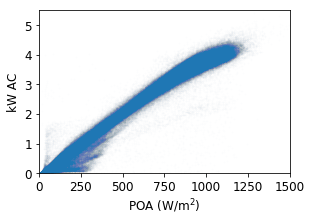

In [5]:
fig, ax = plt.subplots()
ax.plot(df.poa, df.power, 'o', alpha = 0.01)
ax.set_xlim(0,1500)
ax.set_ylim(0, 5.5)
ax.set_ylabel('kW AC')
ax.set_xlabel('POA (W/m$^2$)');

In [6]:
# Calculate temperature
df_temp = pvlib.pvsystem.sapm_celltemp(df.poa, df.wind, df.Tamb, model = 'open_rack_cell_polymerback')
df['Tcell'] = df_temp.temp_cell

In [7]:
# Run a PVWatts model for the dc performance
df['pvw_dc'] = pvlib.pvsystem.pvwatts_dc(df.poa, df.Tcell, pdc, -0.005)

In [8]:
# aggregate what we need for soiling daily
pm = df.power.resample('D').sum() / df.pvw_dc.resample('D').sum()
insol = df.poa.resample('D').sum()
precip = df.precip.resample('D').sum()

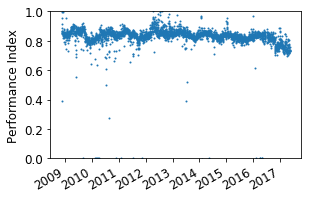

In [9]:
fig, ax = plt.subplots()
ax.plot(pm.index, pm, 'o')
ax.set_ylim(0,1)
fig.autofmt_xdate()
ax.set_ylabel('Performance Index');

# Soiling calculations

In [10]:
# First create a performance metric dataframe
pm_frame = soiling.create_pm_frame(pm, insol, precip = precip)

In [11]:
# Then calculate a results frame summarizing the soiling intervals
results = pm_frame.calc_result_frame()

In [12]:
# Finally perform the monte carlo simulations for the different assumptions
soiling_ratio_realizations = results.calc_monte(1000)

In [13]:
# show the median and confidence interval for irradiance weighted soiling ratio
np.percentile(soiling_ratio_realizations, [2.5, 50, 97.5])

array([ 0.96648202,  0.97604467,  0.98140018])